In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import sys
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [2]:
import astropy.units as u
import lightkurve as lk

In [3]:
def fold(lc, period, t0):
    t0_btjd = t0 - 2457000
    return lc.fold(period=period, epoch_time=t0_btjd)

class TESSPlanetTransit:
    def __init__(self, name, period=None, t0=None, lc = None):
        self.name = name
        self.period = period
        self.t0 = t0
        folded_lc = fold(lc, period, t0)
        self.time = folded_lc.time.value
        self.flux = folded_lc.flux.value
    
    


In [4]:
import pickle

with open("transits_raw.pkl", "rb") as f:

    transits = pickle.load(f)


In [5]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

I had to decrease the number of points in each transit becauses generating too much points seem to really stress the algorithm out (I'm getting losses of NaN...). Given that my data is phase-folded, I hope this doesn't change the general trend of the data too much.

In [6]:
SIZE = 4096
def resample_phase_flux(phase, flux, target_len=SIZE):
    
    flux = np.array(flux)
    phase = np.array(phase)
    mask = ~np.isnan(phase) & ~np.isnan(flux)

    phase = phase[mask]
    flux = flux[mask]

    sort_idx = np.argsort(phase)
    phase = phase[sort_idx]
    flux = flux[sort_idx]

    phase_target = np.linspace(phase[0],phase[-1], target_len)

    flux_interp = np.interp(phase_target, phase, flux)
    
    
    flux_interp = (flux_interp - np.min(flux_interp)) / (np.max(flux_interp) - np.min(flux_interp))

    return np.stack([phase_target, flux_interp], axis=-1)

data = []
for i in range(len(transits)):
    data.append(resample_phase_flux(transits[i].time, transits[i].flux))

data = np.array(data)
data.shape

(4949, 4096, 2)

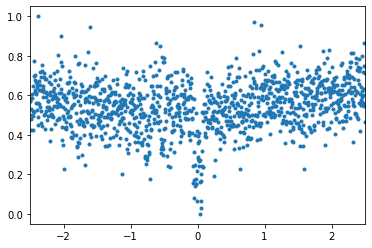

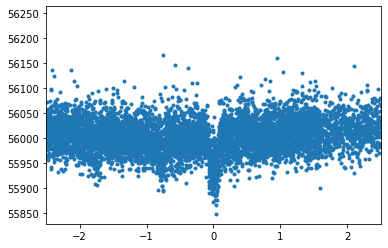

In [7]:
# plt.plot(data[0][:,0], data[0][:,1])
# plt.show()
# plt.plot(data[1][:,0], data[1][:,1])
# plt.show()
plt.plot(data[2][:,0], data[2][:,1],".")
plt.xlim(-2.5,2.5)
plt.show()

plt.plot(transits[2].time, np.array(transits[2].flux),".")
plt.xlim(-2.5,2.5)
plt.show()


In [8]:
LATENT_SPACE_SIZE = 16
input_data = tensorflow.keras.layers.Input(shape=(SIZE, 2))
encoded = tensorflow.keras.layers.Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_data)
encoded = tensorflow.keras.layers.MaxPooling1D(pool_size=2)(encoded)

encoded = tensorflow.keras.layers.Conv1D(16, kernel_size=5, activation='relu', padding='same')(encoded)
encoded = tensorflow.keras.layers.MaxPooling1D(pool_size=2)(encoded)

encoded = tensorflow.keras.layers.Conv1D(8, kernel_size=5, activation='relu', padding='same')(encoded)
encoded = tensorflow.keras.layers.MaxPooling1D(pool_size=2)(encoded)


encoded = tensorflow.keras.layers.Flatten()(encoded)
encoded = tensorflow.keras.layers.Dense(32, activation='relu')(encoded)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(encoded)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(encoded)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])


encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 32)     352         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 2048, 32)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2048, 16)     2576        ['max_pooling1d[0][0]']          
                                                                                              

In [9]:
decoder_input = tensorflow.keras.layers.Input(shape=LATENT_SPACE_SIZE)
decoded = tensorflow.keras.layers.Dense(512 * 8, activation='relu')(decoder_input)
decoded = tensorflow.keras.layers.Reshape((512, 8))(decoded)

decoded = tensorflow.keras.layers.UpSampling1D(2)(decoded)
decoded = tensorflow.keras.layers.Conv1DTranspose(8, kernel_size=5, activation='relu', padding='same')(decoded)
decoded = tensorflow.keras.layers.UpSampling1D(2)(decoded)
decoded = tensorflow.keras.layers.Conv1DTranspose(16, kernel_size=5, activation='relu', padding='same')(decoded)
decoded = tensorflow.keras.layers.UpSampling1D(2)(decoded)
decoded = tensorflow.keras.layers.Conv1DTranspose(32, kernel_size=5, activation='relu', padding='same')(decoded)



decoder_output = tensorflow.keras.layers.Conv1DTranspose(2, kernel_size=5, activation='sigmoid', padding='same')(decoded)

# phase_out = tensorflow.keras.layers.Conv1DTranspose(1, kernel_size=5, activation='linear', padding='same')(decoded)
# flux_out = tensorflow.keras.layers.Conv1DTranspose(1, kernel_size=5, activation='sigmoid', padding='same')(decoded)
# decoder_output = tensorflow.keras.layers.Concatenate(axis=-1)([phase_out, flux_out])

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              69632     
                                                                 
 reshape (Reshape)           (None, 512, 8)            0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 1024, 8)          0         
 )                                                               
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1024, 8)          328       
 nspose)                                                         
                                                                 
 up_sampling1d_1 (UpSampling  (None, 2048, 8)          0   

In [10]:
encoded_train = encoder_model(input_data)
decoded_train = decoder_model(encoded_train)
autoencoder = tensorflow.keras.Model(input_data, decoded_train)

In [11]:


def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(
            y_true[:, :, 1],  # true flux
            y_pred[:, :, 1]   # predicted flux
        )
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        print_op = tensorflow.print("\nmse", 0.5*reconstruction_loss_batch*factor, output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = 0.5*reconstruction_loss_batch*factor
        return res

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        print_op = tensorflow.print("\nvariance", distribution_variance, output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            distribution_variance = tensorflow.clip_by_value(distribution_variance, -10.0, 10.0)
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        print_op = tensorflow.print("\nkl", kl_loss_batch*(-0.5), output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = kl_loss_batch*(-0.5)
        return res

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [12]:
X_train, X_test = train_test_split(data, test_size=0.2)


In [13]:
batch_size = 64
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 1.0,
                                  batch_size = batch_size), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 2)]         0         
                                                                 
 model (Functional)          (None, 16)                135736    
                                                                 
 model_1 (Functional)        (None, 4096, 2)           73530     
                                                                 
Total params: 209,266
Trainable params: 209,266
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_test, X_test))

Train on 3959 samples, validate on 990 samples
Epoch 1/50
3959/3959 [==============================] - ETA: 0s - loss: 161.9352

/Users/nina/anaconda3/envs/sds365/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3959/3959 [==============================] - 105s 27ms/sample - loss: 161.9352 - val_loss: -66.7273
Epoch 2/50
3959/3959 [==============================] - 46s 12ms/sample - loss: -65.5602 - val_loss: -66.7837
Epoch 3/50
3959/3959 [==============================] - 48s 12ms/sample - loss: -65.5917 - val_loss: -66.7440
Epoch 4/50
3959/3959 [==============================] - 45s 11ms/sample - loss: -65.7816 - val_loss: -67.1638
Epoch 5/50
3959/3959 [==============================] - 51s 13ms/sample - loss: -65.9259 - val_loss: -67.4359
Epoch 6/50
3959/3959 [==============================] - 48s 12ms/sample - loss: -65.9431 - val_loss: -67.0797
Epoch 7/50
3959/3959 [==============================] - 51s 13ms/sample - loss: -65.9354 - val_loss: -67.0614
Epoch 8/50
3959/3959 [==============================] - 45s 11ms/sample - loss: -65.9727 - val_loss: -67.2198
Epoch 9/50
3959/3959 [==============================] - 42s 11ms/sample - loss: -65.9686 - val_loss: -67.2038
Epoch 10/50
3959/395

In [15]:
autoencoder.save("My_Trained_VAE")
encoder_model.save("My_Trained_encoder")
decoder_model.save("My_Trained_decoder")

INFO:tensorflow:Assets written to: My_Trained_VAE/assets


INFO:tensorflow:Assets written to: My_Trained_VAE/assets


INFO:tensorflow:Assets written to: My_Trained_encoder/assets


INFO:tensorflow:Assets written to: My_Trained_encoder/assets


INFO:tensorflow:Assets written to: My_Trained_decoder/assets


INFO:tensorflow:Assets written to: My_Trained_decoder/assets


Text(0.5, 1.0, 'Reconstructed')

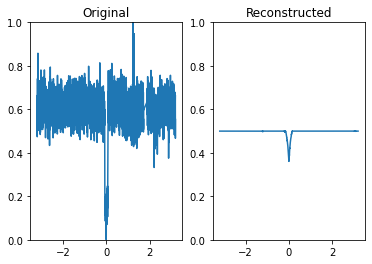

In [22]:
one_sample = X_test[20]
fig, axs = plt.subplots(1, 2)
axs[0].plot(one_sample[:,0], one_sample[:,1])
axs[0].set_ylim(0,1)
axs[0].set_title("Original")
reconstructed = autoencoder.predict(one_sample.reshape(1, SIZE, 2))[0]
axs[1].plot(one_sample[:,0], reconstructed[:,1])
axs[1].set_ylim(0,1)
axs[1].set_title("Reconstructed")


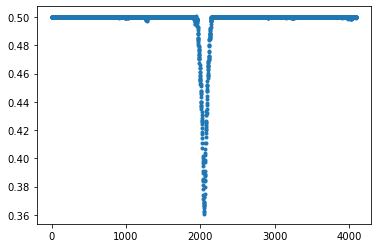

In [23]:
plt.plot(reconstructed[:,1],".")


In [18]:
def GenerateTransits(data, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(data)), 15)
    latent_space = noise_level*np.random.normal(size=(15,LATENT_SPACE_SIZE))+encoder_model.predict(data[sample_index])
    generated_transit = decoder_model.predict(latent_space)
    fig = plt.figure(figsize=(15,10))
    number_of_images = len(generated_transit)
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.plot(generated_transit[i][:,1])
    return generated_transit

/Users/nina/anaconda3/envs/sds365/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


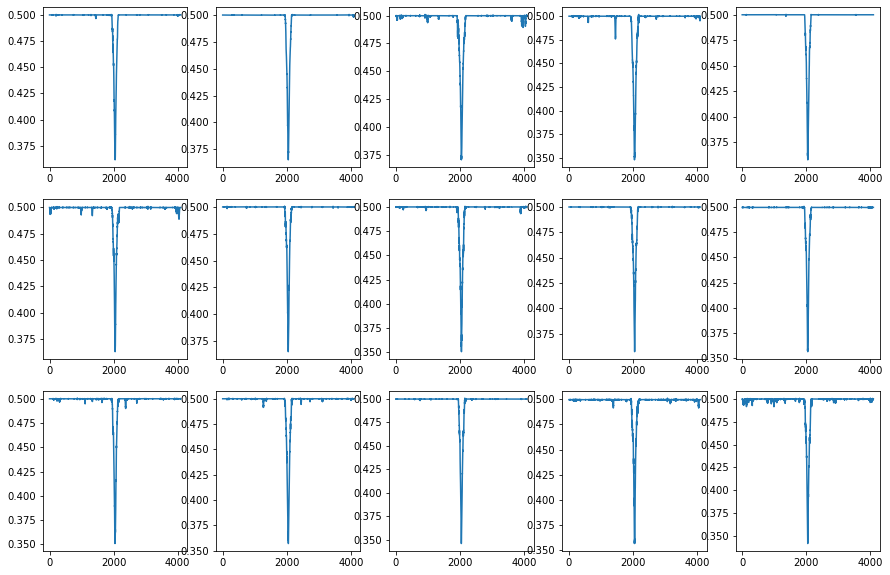

In [19]:
generated_transits = GenerateTransits(data, LATENT_SPACE_SIZE, 0.5)